# Deepwalk-HPP

Deepwalk-HPP is a Python repository that implements house representation learning using DeepWalk, a network representation learning technique. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx  
from scipy.spatial.distance import pdist, squareform  
from tqdm import tqdm  

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error , r2_score, mean_squared_error

from gensim.models import Word2Vec
import json
import plotly.express as px
import networkx as nx
from geopy.distance import geodesic
from scipy.spatial import cKDTree
import random
from csrgraph import csrgraph

# Set the seed 
seed = 42 
random.seed(seed) 
np.random.seed(seed)

# Load the real estate dataset

In [2]:
data= pd.read_excel('data/MHD-housing.xlsx')
data.head()

,type,area_sq_m,latitude,longitude,age_years,floor_number,number_of_bedrooms,price,region,elevator,...,stone_façade,garden,direction,furnished,renovated,closet,em_mos,repainted,property_document_type,utilities_included
0,0,73.0,36.373776,59.475820,11,1,2,2200000000,12,1,...,0,0,0,0,0,0,0,0,1,4
1,0,100.0,36.327670,59.548380,7,1,2,4800000000,2,1,...,0,0,0,0,0,0,0,0,0,3
2,0,140.0,36.310605,59.504477,0,2,2,10200000000,9,1,...,0,1,1,0,0,0,0,0,1,4
3,0,65.0,36.400540,59.388382,6,4,1,870000000,12,0,...,0,0,0,0,0,1,1,1,2,0
4,0,200.0,36.373776,59.475820,0,0,3,5350000000,12,1,...,0,0,1,0,0,0,0,0,1,4


In [3]:
data.columns

Index(['type', 'area_sq_m', 'latitude', 'longitude', 'age_years',
       'floor_number', 'number_of_bedrooms', 'price', 'region', 'elevator',
       'parking', 'storage', 'shop', 'balcony', 'full_amenities', 'parquet',
       'ceramic_flooring', 'stone_façade', 'garden', 'direction', 'furnished',
       'renovated', 'closet', 'em_mos', 'repainted', 'property_document_type',
       'utilities_included'],
      dtype='object')

In [4]:
data.shape

(44781, 27)

In [5]:
# Check if there are any NaN values in the DataFrame
has_nan = data.isnull().any().any()
print(has_nan)  # True if there are any NaN values

False


Filter outliers for visulatization

In [6]:
filtered_data1 = data[(data['longitude'] >= 59.4) & (data['longitude'] <= 59.7) & 
                 (data['latitude'] >= 36.2) & (data['latitude'] <= 36.45)]

filtered_data1.shape

(44725, 27)

In [7]:
import plotly.express as px
import plotly.graph_objects as go

# Filter the data for the specified region
filtered_data1 = data[(data['longitude'] >= 59.4) & (data['longitude'] <= 59.7) & 
                      (data['latitude'] >= 36.2) & (data['latitude'] <= 36.45)]

# Create the scatter plot
fig = px.scatter(
    filtered_data1, 
    x="longitude", 
    y="latitude", 
    color="price", 
    color_continuous_scale="turbo",  
    width=400, 
    height=400
)

# Adjust marker size and opacity
fig.update_traces(marker=dict(size=4, opacity=0.9))

# Define the rectangle coordinates (High Demand Area)
rect_x0, rect_x1 = 59.45, 59.55  # Longitude range
rect_y0, rect_y1 = 36.28, 36.4   # Latitude range

# Add the rectangle to the plot
fig.add_trace(go.Scatter(
    x=[rect_x0, rect_x1, rect_x1, rect_x0, rect_x0],  # Rectangle x-coordinates
    y=[rect_y0, rect_y0, rect_y1, rect_y1, rect_y0],  # Rectangle y-coordinates
    mode="lines",  # Draw lines to form the rectangle
    fill="toself",  # Fill the rectangle
    fillcolor="rgba(0,0,0,0.1)",  # Fill color (black with 0.2 opacity)
    line=dict(color="gray", width=2),  # Rectangle border color and width
    name="High Demand Area"  # Label for the rectangle
))

# Remove the legend for the rectangle
fig.update_traces(showlegend=False)

# Display the plot
fig.show()

## Filter the data to focus on properties within a high demand region

In [8]:
# Filter the data for the high-demand area (rectangle boundaries)
filtered_data = data[
    (data['longitude'] >= rect_x0) & (data['longitude'] <= rect_x1) & 
    (data['latitude'] >= rect_y0) & (data['latitude'] <= rect_y1)
]

# Check the shape of the filtered data
filtered_data.shape

(29452, 27)

Randomly sample 5,000 data points from the filtered dataset

This creates a smaller, manageable dataset for analysis while maintaining diversity and reducing potential bias from any inherent order in the original data

In [9]:
np.random.seed(42)
shuffle_indices = np.random.choice(np.arange(filtered_data.shape[0]), size=5000, replace=False,)
df = filtered_data.iloc[shuffle_indices].reset_index(drop=True)
df['id'] = df.index  # Add this line to create a unique identifier for each house  
len(df) #, df.head(2)

5000

Visualize the spatial distribution of the selected properties using a scatter plot

In [10]:
# import plotly.express as px
# px.scatter(df , x="longitude", y="latitude",  width=400, height=400)#.write_image("img/spatial_distribution.png")

In [11]:
fig = px.scatter(
    df, 
    x="longitude", 
    y="latitude", 
    color="price", 
    color_continuous_scale="turbo",  
    width=350, 
    height=400
)
fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.show()

Creates a NetworkX graph of houses in the dataset

In [12]:
import networkx as nx  
import pandas as pd  
from sklearn.preprocessing import StandardScaler  
from scipy.spatial import cKDTree  
import numpy as np  
from tqdm import tqdm  

def create_graph_from_dataframe(df, distance_threshold):  
    """  
    Create a graph from a DataFrame of property features, with edges based on  
    geographic proximity and weighted by property attributes.  

    Parameters:  
    - df: pd.DataFrame containing property features.  
    - distance_threshold: float, the distance threshold in meters for creating edges.  

    Returns:  
    - G: networkx.Graph, the generated graph with nodes and weighted edges.  
    """  
    # Separate numerical and binary features  
    numeric_features = ['area_sq_m', 'age_years', 'floor_number', 'number_of_bedrooms']  
    binary_features = ['elevator', 'parking', 'storage', 'balcony', 'parquet',   
                      'ceramic_flooring', 'stone_façade', 'garden', 'renovated']  
    
    # Normalize numeric features  
    scaler = StandardScaler()  
    df[numeric_features] = scaler.fit_transform(df[numeric_features])  

    # Build spatial index with cKDTree  
    coordinates = df[['latitude', 'longitude']].to_numpy()  
    tree = cKDTree(coordinates)  

    # Initialize graph  
    G = nx.Graph()  

    # Add nodes with attributes using the new 'id' column  
    # for i, row in df.iterrows():  
    #     G.add_node(row['id'], **row.to_dict())  # Use the 'id' as the node identifier  

    for i, row in df.iterrows():
        node_id = int(row['id'])
        G.add_node(node_id, **row.to_dict())

    # Find pairs of nodes within the threshold distance  
    pairs = tree.query_pairs(distance_threshold / 111000)  # Approximate meter-to-degree conversion  

    # Define a function to compute edge weight  
    def calculate_weight(df, idx1, idx2):  
        # no edge if the types are different  
        if df.loc[idx1, 'type'] != df.loc[idx2, 'type']:  
            return 0  
        geo_distance = np.linalg.norm(coordinates[idx1] - coordinates[idx2])  
        # num_distance = np.linalg.norm(df.loc[idx1, numeric_features] - df.loc[idx2, numeric_features])  
        # binary_similarity = np.sum(df.loc[idx1, binary_features] == df.loc[idx2, binary_features])   
        # weight = (1 / (1 + geo_distance)) * (1 + binary_similarity) / (1 + num_distance)  

        weight = (1 / (1 + geo_distance))  
        return weight  

    # Add edges with weights  
    for idx1, idx2 in tqdm(pairs):  
        weight = calculate_weight(df, idx1, idx2)  
        if weight != 0:  
            G.add_edge(df.at[idx1, 'id'], df.at[idx2, 'id'], weight=weight)  # Use ids for edges  

    return G  

In [13]:
# df['id'] = df['id'].astype(int)
G = create_graph_from_dataframe(df, distance_threshold=50) 

100%|██████████| 1472730/1472730 [00:46<00:00, 31477.12it/s]


In [14]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [15]:
def is_complete_graph(G):
    n = G.number_of_nodes()
    if n < 2:
        return True  # A graph with 0 or 1 node is considered complete
    max_edges = n * (n - 1) // 2
    print(G.number_of_edges(), max_edges)
    return G.number_of_edges() == max_edges

In [16]:
print("G is complete:", is_complete_graph(G)) 

1415153 12497500
G is complete: False


In [17]:
# len(G.edges()), G.nodes[0]

In [18]:
# import pickle

# with open('var/graph-NW-dist-1000-5000.pkl', 'wb') as f:
#     pickle.dump(G, f)

In [19]:
# import pickle
# with open('var/graph-dist-1000.pkl', 'rb') as f:
#     G = pickle.load(f)

In [20]:
df.head(1)

,type,area_sq_m,latitude,longitude,age_years,floor_number,number_of_bedrooms,price,region,elevator,...,garden,direction,furnished,renovated,closet,em_mos,repainted,property_document_type,utilities_included,id
0,0,-0.81362,36.322826,59.49541,0.650667,0.853148,-1.977046,2900000000,9,1,...,0,-1,0,0,0,0,0,1,4,0


In [21]:
import random  
import plotly.graph_objects as go  
import networkx as nx  
import pandas as pd  

# Assuming df is your dataframe with columns 'id', 'longitude', and 'latitude',  
# and G is the network graph created from the dataframe `df`.  

# Step 1: Select a random node from the graph  
random_node = random.choice(list(G.nodes))  

# Step 2: Get edges connected to the random node  
edges = G.edges(random_node)  

# Step 3: Collect all nodes to plot: random node plus its neighbors  
nodes_to_plot = [random_node] + list(G.neighbors(random_node))  

# Step 4: Filter the dataframe to get coordinates for selected nodes  
selected_houses = df[df['id'].isin(nodes_to_plot)]  

# Step 5: Create a Geo Scatter Plot for visible nodes  
fig = go.Figure()  

# Step 6: Plot edges  
for u, v in edges:  
    if u in selected_houses['id'].values and v in selected_houses['id'].values:  
        u_coords = selected_houses[selected_houses['id'] == u][['longitude', 'latitude']].values[0]  
        v_coords = selected_houses[selected_houses['id'] == v][['longitude', 'latitude']].values[0]  

        # Draw edges on the plot  
        fig.add_trace(go.Scattergeo(  
            lon=[u_coords[0], v_coords[0]],  
            lat=[u_coords[1], v_coords[1]],  
            mode='lines',  
            line=dict(width=1, color='blue'),  
            showlegend=False  
        ))  

# Step 7: Highlight the random node in red  
random_node_coords = selected_houses[selected_houses['id'] == random_node]  
fig.add_trace(go.Scattergeo(  
    lon=random_node_coords['longitude'],  
    lat=random_node_coords['latitude'],  
    mode='markers',  
    marker=dict(size=10, color='red', symbol='circle'),  # Random node in red  
    name='Random Node'  
))  

# Step 8: Adding selected (neighbors) houses to the plot  
fig.add_trace(go.Scattergeo(  
    lon=selected_houses['longitude'],  
    lat=selected_houses['latitude'],  
    mode='markers',  
    marker=dict(size=6, color='green', symbol='square'),  # Selected neighbors in green  
    name='Selected Neighbors'  
))  

# Step 9: Adding a subset of other houses to the plot (not selected)  
all_houses = df[df['id'].isin(list(G.nodes))]  
other_houses = all_houses[~all_houses['id'].isin(nodes_to_plot)]  # Exclude selected nodes  

# Randomly select a subset of other houses (e.g., 100)  
subset_size = min(1000, len(other_houses))  # Ensure we don't exceed the available number  
other_houses_sampled = other_houses.sample(n=subset_size, random_state=1)  # Sample random houses  

fig.add_trace(go.Scattergeo(  
    lon=other_houses_sampled['longitude'],  
    lat=other_houses_sampled['latitude'],  
    mode='markers',  
    marker=dict(size=5, color='blue', symbol='circle'),  # Other houses in blue  
    name='Other Houses'  
))  

# Step 10: Update layout to focus on a high demand area  
fig.update_layout(  
    title='Houses with Edges from a Random Node',  
    geo=dict(  
        scope='asia',  # Set the scope to Asia for better overview  
        projection_type='mercator',  
        showland=True,  
        landcolor='lightgray',  
        countrycolor='white',  
        fitbounds="locations",  # Automatically fits the map to all locations  
        center=dict(lon=random_node_coords['longitude'].values[0], lat=random_node_coords['latitude'].values[0])  # Center on random node  
    )  
)  

# Step 11: Show the final plot  
fig.show()

In [22]:
import networkx as nx  
import pandas as pd  
import matplotlib.pyplot as plt  

# Assuming G is your NetworkX graph created from the df DataFrame  
# and df contains the relevant house data with longitude and latitude  

# Step 1: Calculate basic statistics  
num_nodes = G.number_of_nodes()  
num_edges = G.number_of_edges()  
degrees = [len(list(G.neighbors(node))) for node in G.nodes]  # List of number of neighbors for each node  

# Step 2: Compute minimum, maximum, and average number of neighbors  
min_neighbors = min(degrees)  
max_neighbors = max(degrees)  
avg_neighbors = sum(degrees) / num_nodes if num_nodes > 0 else 0  

# Step 3: Create a DataFrame for a better overview  
degree_distribution = pd.DataFrame({  
    'Node ID': list(G.nodes),  
    'Num Neighbors': degrees  
})  

# Step 4: Summary statistics of the degree distribution  
degree_stats = degree_distribution['Num Neighbors'].describe()  

# Step 5: Output the results  
print(f"Total number of nodes: {num_nodes}")  
print(f"Total number of edges: {num_edges}")  
print(f"Minimum number of neighbors: {min_neighbors}")  
print(f"Maximum number of neighbors: {max_neighbors}")  
print(f"Average number of neighbors: {avg_neighbors:.2f}")  
print("\nDegree Distribution Summary:")  
print(degree_stats)  

# # Visualize the degree distribution  
# plt.figure(figsize=(10, 6))  
# degree_distribution['Num Neighbors'].hist(bins=range(1, max_neighbors + 2), alpha=0.7, color='skyblue')  
# plt.title('Degree Distribution of Houses')  
# plt.xlabel('Number of Neighbors')  
# plt.ylabel('Frequency')  
# plt.xticks(range(1, max_neighbors + 2))  
# plt.grid(axis='y')  

# # Step 6: Save the plot as PNG file  
# plt.savefig('results/MHD/degree_distribution_houses.png')  # Save the figure  

# # Show the plot  
# plt.show()

Total number of nodes: 5000
Total number of edges: 1415153
Minimum number of neighbors: 0
Maximum number of neighbors: 1514
Average number of neighbors: 566.06

Degree Distribution Summary:
count    5000.000000
mean      566.061200
std       638.224733
min         0.000000
25%        60.000000
50%       241.000000
75%      1514.000000
max      1514.000000
Name: Num Neighbors, dtype: float64


In [23]:
import numpy as np  

def random_walk(start, length):  
    walk = [str(start)]  # Starting node  

    for i in range(length):  
        # Get the neighbors of the current node  
        neighbors = [node for node in G.neighbors(start)]  
        
        # Check if the node has neighbors  
        if len(neighbors) == 0:  
            next_node = start  # If no neighbors, stay in the same node  
        else:  
            next_node = np.random.choice(neighbors, 1)[0]  # Choose a neighbor at random  
        
        walk.append(str(next_node))  
        start = next_node  # Move to the next node  
    
    return walk

In [24]:
nx.is_connected(G)

False

In [25]:
%%time
from tqdm import tqdm  

def generate_random_walks(subgraph, num_walks=80, walk_length=20, return_weight=3, neighbor_weight=1):#walk_length=10):  
    """  
    Generate random walks for each node in the given subgraph.  

    Parameters:  
    - subgraph: The graph from which to generate random walks.  
    - num_walks: The number of random walks to generate for each node.  
    - walk_length: The length of each random walk.  

    Returns:  
    - A list of random walks.  
    """  
    G = csrgraph(subgraph)
    n = G.nnodes
    # walk_length = 10  # Length of each walk
    walks = []
    for i in tqdm(range(num_walks)): 
        random_walks = G.random_walks(walklen=walk_length, return_weight=return_weight, neighbor_weight=neighbor_weight) 
        for walk in random_walks:
            # # Convert each element in the walk array to a string
            walk_str = [str(node) for node in walk.tolist()]
            walks.append(walk_str)  # Append the list of strings to walks
    return walks  

# w = generate_random_walks(G, num_walks=2)    
# w[0], type(w), len(w), len(w[0]), w[0]  

CPU times: total: 0 ns
Wall time: 0 ns


In [26]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error  
from sklearn.model_selection import train_test_split, KFold  
from sklearn.ensemble import GradientBoostingRegressor  
# from gensim.models.word2vec import Word2Vec  

def fit_and_evaluate(model, X_train, y_train, X_test, y_test, filename=None, verbose=True, tolerance=0.2):  
    # Fit the model  
    model.fit(X_train, y_train)  

    # Make predictions  
    y_pred = model.predict(X_test)  

# Check for zero or negative values in y_test and y_pred
    epsilon = 1e-10  # Small positive value to replace zeros
    mean_y_test = np.mean(y_test)  # Mean value of y_test

    # Replace zero or negative values in y_test
    if (y_test <= 0).any():
        print("y_test contains zero or negative values. Replacing with mean.")
        y_test = np.where(y_test <= 0, mean_y_test, y_test)  # Replace with mean_y_test

    # Replace zero or negative values in y_pred
    if (y_pred <= 0).any():
        print("y_pred contains zero or negative values. Replacing with mean.")
        y_pred = np.where(y_pred <= 0, mean_y_test, y_pred)  # Replace with mean_y_test

    # Metrics  
    r2 = r2_score(y_test, y_pred)  
    mape = mean_absolute_percentage_error(y_test, y_pred)  
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse_log = mean_squared_error(np.log10(y_test), np.log10(y_pred))

    # Range accuracy  
    correct_count = np.sum(np.abs(y_test - y_pred) <= tolerance * y_test)  
    accuracy = correct_count / len(y_test)  

    # Scatterplot  
    if verbose:  
        plt.scatter(y_test, y_pred)  
        plt.xlabel('Actual Prices')  
        plt.ylabel('Predicted Prices')  
        plt.title('Actual vs Predicted Prices')  
        if filename:  # Save only if filename is provided  
            plt.savefig(filename, format='png')  
        plt.close()  

    if verbose:  
        print(f"R2 Score: {r2}, MAPE: {mape}, RMSE: {rmse}, Accuracy: {accuracy}")  

    return r2, mape, accuracy, rmse, mse_log

def create_word2vec_model(walks, vector_size):  
    model = Word2Vec(walks,  
                     hs=1,   # Hierarchical softmax  
                     sg=1,   # Skip-gram  
                     vector_size=vector_size,  
                     window=5,  
                     workers=4,  
                     seed=1)  
    return model  


def get_embeddings(model, G):  
    return np.array([model.wv[str(i)] for i in G.nodes()])  
    
def word2vec_model(df, G, vector_size):
    walks = generate_random_walks(G)
    wv_model = create_word2vec_model(walks, vector_size=vector_size)#, p=.5, q=4)  
    embeddings = get_embeddings(wv_model, G)    
    # print(node2vec_embeddings.shape)
    embeddings_df = pd.DataFrame(embeddings, columns=[f'node2vec_embedding_{i}' for i in range(embeddings.shape[1])])  
    # df_with_embeddings = pd.concat([df_filtered.reset_index(drop=True), embeddings_df], axis=1)  
    df_with_embeddings = pd.concat([df, embeddings_df], axis=1)  

    # Prepare for Regression  
    X = df_with_embeddings.drop(['price', 'id'], axis=1)  
    y = df_with_embeddings['price']  
    return X, y


In [27]:
import numpy as np  
import pandas as pd  
from sklearn.model_selection import train_test_split, KFold  
from sklearn.ensemble import GradientBoostingRegressor  
import matplotlib.pyplot as plt  

def grid_search_embedding_size(df, G, embedding_sizes, score_name='rmse', random_state=42):  
    # Initialize best score and parameters  
    best_score = np.inf if score_name == 'rmse' else -np.inf  
    best_params = None  
    best_X = None  
    best_y = None  

    # To store scores for each embedding size  
    results = []  

    for vector_size in embedding_sizes:  
        print(f"Evaluating embedding size: {vector_size}")   
        
        X, y = word2vec_model(df, G, vector_size)  
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.1, random_state=random_state)  
        
        # Cross-validation  
        kf = KFold(n_splits=5, shuffle=True, random_state=random_state)  
        scores = []  

        for train_index, val_index in kf.split(X_train):  
            X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]  
            y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]  
            
            model = GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=10, random_state=random_state)   
            if score_name == 'rmse':
                _, _, _, score, _ = fit_and_evaluate(model, X_train_kf, y_train_kf, X_val_kf, y_val_kf, verbose=False)  
            else:
                score, _, _, _, _ = fit_and_evaluate(model, X_train_kf, y_train_kf, X_val_kf, y_val_kf, verbose=False)  
            scores.append(score)  

        mean_score = np.mean(scores)  
        print(f"Mean {score_name} for embedding size {vector_size}: {mean_score}")  

        # Store results  
        results.append((vector_size, mean_score))  

        # Update best score and parameters  
        if score_name == 'rmse':
            condition = mean_score < best_score
        else:
            condition = mean_score > best_score 
        if condition == True: 
            best_score = mean_score   
            best_params = vector_size  
            best_X = X  
            best_y = y  

    print(f"Best embedding size: {best_params} with {score_name}: {best_score}")  
    
    # Create DataFrame from results  
    results_df = pd.DataFrame(results, columns=['Embedding Size', score_name])  
    
    return best_params, best_X, best_y, results_df  # Return best parameters, X, y, and results DataFrame  

def plot_results(results_df, best_params, best_score, score_name):  
    # Plotting using matplotlib for visualization  
    plt.figure(figsize=(12, 8))  
    plt.plot(results_df['Embedding Size'], results_df[score_name], marker='o', color='blue', label=score_name.upper())  
    plt.scatter(best_params, best_score, color='red', label=f'Best Embedding Size ({best_params})')  
    plt.xlabel('Embedding Size')  
    plt.ylabel(score_name.upper())  
    plt.xticks(results_df['Embedding Size'])  
    plt.title(f'Embedding Size vs {score_name.upper()}')  
    plt.grid(True)  
    plt.savefig('results/MHD/embedding_size_plot.png')  # Save the plot as an image  
    plt.show()  

Evaluating embedding size: 2


100%|██████████| 80/80 [26:54<00:00, 20.18s/it]


Mean r2 for embedding size 2: 0.7567443914700004
Evaluating embedding size: 5


100%|██████████| 80/80 [27:23<00:00, 20.55s/it]


Mean r2 for embedding size 5: 0.7640161962901412
Evaluating embedding size: 10


100%|██████████| 80/80 [27:38<00:00, 20.73s/it]


Mean r2 for embedding size 10: 0.7631540695935686
Evaluating embedding size: 15


100%|██████████| 80/80 [26:19<00:00, 19.74s/it]


Mean r2 for embedding size 15: 0.7632292609483124
Evaluating embedding size: 20


100%|██████████| 80/80 [27:26<00:00, 20.58s/it]


Mean r2 for embedding size 20: 0.7701095314558285
Best embedding size: 20 with r2: 0.7701095314558285


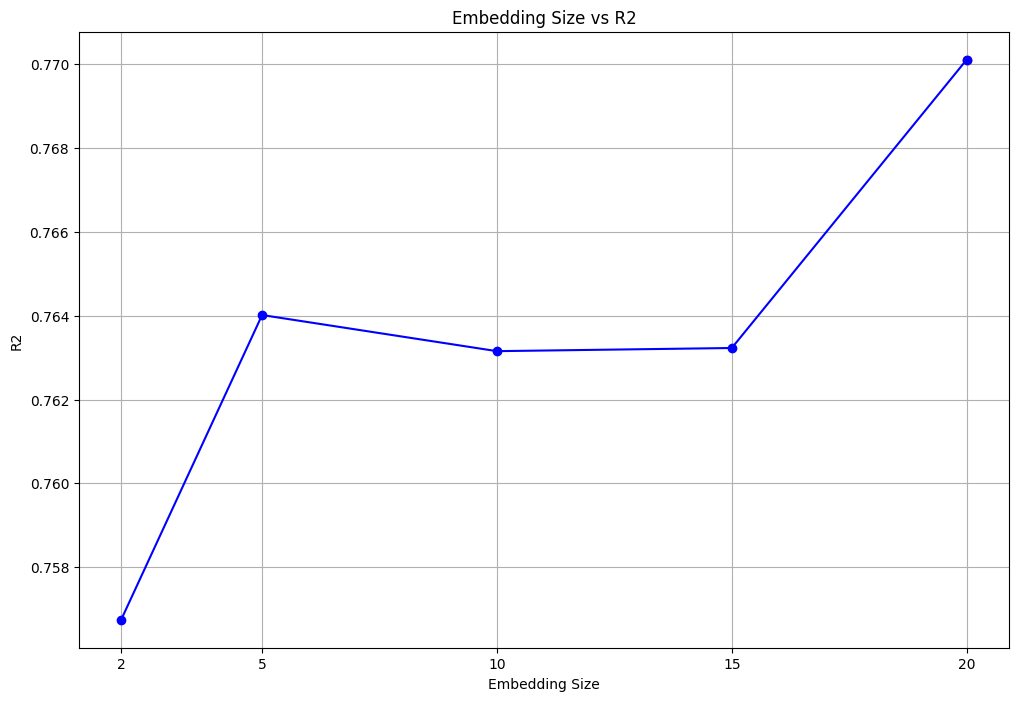

CPU times: total: 16h 38min 46s
Wall time: 2h 26min 41s


In [28]:
%%time

score_name='r2' #or 'rmse'
# Perform grid search on the training set  
embedding_sizes = [2, 5, 10, 15, 20] 
best_embedding_size, X, y, results_df = grid_search_embedding_size(df, G, embedding_sizes, score_name=score_name)  

# Save results to Excel  
results_df.to_excel('results/MHD/embedding_size_results.xlsx', index=False)  

# Plotting  
plot_results(results_df, best_embedding_size, results_df.loc[results_df['Embedding Size'] == best_embedding_size].iloc[0][score_name], score_name)  

# Generate TikZ/PGF code  
# tikz_code = generate_tikz(results_df, best_embedding_size, results_df.loc[results_df['Embedding Size'] == best_embedding_size].iloc[0][score_name], score_name)  
# print(tikz_code)

In [29]:
import pickle

data_set_name = 'MHD'
# Collect results into a dictionary
grid_search_results = {
    'data_set_name' : data_set_name,
    'best_embedding_size': best_embedding_size,
    'X': X,
    'y': y,
    'results_df': results_df,
    'score_name': score_name,
    'embedding_sizes': embedding_sizes
}

# Generate a filename based on the parameters
filename = f"var/grid_search_results_{data_set_name}_{score_name}_embedding_{'_'.join(map(str, embedding_sizes))}_r-50.pkl"

# Save the results to a pickle file
with open(filename, 'wb') as f:
    pickle.dump(grid_search_results, f)

print(f"Grid search results saved to {filename}")

Grid search results saved to var/grid_search_results_MHD_r2_embedding_2_5_10_15_20_r-50.pkl


In [30]:
def generate_tikz(results_df, best_params, best_score, score_name):  
    tikz_code = r"""  
\begin{tikzpicture}  
\begin{axis}[  
    width=12cm,  
    height=8cm,  
    xlabel={Embedding Size},  
    ylabel={""" + f"{score_name.upper()} " + r"""},  
    xtick={""" + ','.join(map(str, results_df['Embedding Size'])) + r"""},  
    ymin=""" + str(results_df[score_name].min()) + r""", ymax=""" + str(results_df[score_name].max()) + r""",  
    grid=both,  
    ticklabel style={/pgf/number format/fixed},  
    legend style={at={(0.5,-0.2)}, anchor=north, legend columns=1},  
    ymajorgrids=true,  
    xmajorgrids=true,  
    every axis plot/.append style={thick}  
]  

% Data points  
\addplot[blue, mark=*] coordinates {  
"""  
    for index, row in results_df.iterrows():  
        tikz_code += f"    ({row['Embedding Size']}, {row[score_name]})\n"  
    
    tikz_code += r"""};   

% Highlight the best embedding size  
\addplot[red, only marks, mark=*] coordinates {  
    ({best_params}, {best_score})  
};  

\legend{""" + f"{score_name.upper()}, Best Embedding Size ({best_params})" + r"""}  

\end{axis}  
\end{tikzpicture}  
"""  
    return tikz_code  

def save_tikz_to_file(tikz_code, filename="tikz_plot.tex"):  
    with open(filename, 'w') as f:  
        f.write(tikz_code)  

# Generate TikZ code  
tikz_code = generate_tikz(results_df, best_embedding_size, results_df.loc[results_df['Embedding Size'] == best_embedding_size].iloc[0][score_name], score_name)  
# Save TikZ code to a file  
save_tikz_to_file(tikz_code, "results/MHD/tikz_plot.tex")

Re-creation of node representation, based on the best embedding size

In [31]:
# best_embedding_size = 3
X, y = word2vec_model(df, G, best_embedding_size)  

100%|██████████| 80/80 [27:01<00:00, 20.27s/it]


In [32]:
X_train_w_embeddings, X_test_w_embeddings, y_train, y_test = train_test_split(X, y,\
                                                test_size=0.1, random_state=42)
X_train_wo_embeddings = X_train_w_embeddings.iloc[:, :-best_embedding_size]
X_test_wo_embeddings = X_test_w_embeddings.iloc[:, :-best_embedding_size]

In [33]:
import pickle
# List of variables to save  
data_to_save = {  
    'X': X,
    'y': y,
    'X_train_wo_embeddings': X_train_wo_embeddings,  
    'X_train_w_embeddings': X_train_w_embeddings,  
    'X_test_wo_embeddings': X_test_wo_embeddings,  
    'X_test_w_embeddings': X_test_w_embeddings,  
    'y_train': y_train,  
    'y_test': y_test,  
    'best_embedding_size': best_embedding_size,  
}  

# Save the variables to a pickle file  
with open('var/data_deepwalk-MHD-r-50.pkl', 'wb') as f:  
    pickle.dump(data_to_save, f)  

print("Variables have been saved to var folder")

Variables have been saved to var folder


In [34]:
# import pickle
# # Load the variables from the pickle file  
# with open('var/data_deepwalk-MHD.pkl', 'rb') as f:  
#     loaded_data = pickle.load(f)  

# # Unpack the loaded data  
# X_train_wo_embeddings = loaded_data['X_train_wo_embeddings']  
# X_train_w_embeddings = loaded_data['X_train_w_embeddings']  
# X_test_wo_embeddings = loaded_data['X_test_wo_embeddings']  
# X_test_w_embeddings = loaded_data['X_test_w_embeddings']  
# y_train = loaded_data['y_train']  
# y_test = loaded_data['y_test']  
# best_embedding_size = loaded_data['best_embedding_size']  

# print("Variables have been loaded successfully!")

## Without Word2Vec

In [35]:
model = GradientBoostingRegressor( loss = 'huber' , n_estimators=100 ,  max_depth=10 , random_state=5 )
r2, mape , accuracy, rmse, mse_log = fit_and_evaluate(model, X_train_wo_embeddings, \
                            y_train, X_test_wo_embeddings, y_test,'results/MHD/prediction_wo-deepwalk.png')

R2 Score: 0.775719984354989, MAPE: 0.17841701977304486, RMSE: 2232917813.3177896, Accuracy: 0.806


In [36]:
print(f"R2 Score: {r2:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MSE (log): {mse_log:.2f}")
print(f"acc: {accuracy:.2f}")
final_score = (r2 + (1 - mape) + accuracy) / 3
print(f'Final score: {final_score:.2f}')

R2 Score: 0.78
MAPE: 0.18
RMSE: 2232917813.32
MSE (log): 0.01
acc: 0.81
Final score: 0.80


In [37]:
# Fit the model on the entire training set  
model_final = GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=10, random_state=5)  
r2_with_deepwalk, mape_with_deepwalk, accuracy_with_deepwalk, rmse_with_deepwalk, mse_log_with_deepwalk = fit_and_evaluate(model_final,\
            X_train_w_embeddings, y_train, X_test_w_embeddings, y_test, 'results/MHD/prediction_w-deepwalk.png', verbose=True)

R2 Score: 0.8179809553149386, MAPE: 0.17476084432912484, RMSE: 2011573310.7171574, Accuracy: 0.79


In [38]:
print(f"R2 Score: {r2_with_deepwalk:.2f}")
print(f"MAPE: {mape_with_deepwalk:.2f}")
print(f"RMSE: {rmse_with_deepwalk:.2f}")
print(f"MSE (log): {mse_log_with_deepwalk:.2f}")
print(f"Accuracy: {accuracy_with_deepwalk:.2f}")
final_score_deepwalk = (r2_with_deepwalk + (1 - mape_with_deepwalk) + accuracy_with_deepwalk) / 3
print(f'Final score: {final_score_deepwalk:.2f}')

R2 Score: 0.82
MAPE: 0.17
RMSE: 2011573310.72
MSE (log): 0.01
Accuracy: 0.79
Final score: 0.81


In [39]:
import numpy as np  
from scipy import stats  

# این مقادیر از مدل ها به دست آمده اند.  
n_samples = X_train_w_embeddings.shape[0]  #تعداد نمونه های داده ها  
rmse_without_deepwalk = rmse  # MSE مدل بدون DeepWalk  
# rmse_with_deepwalk = 0.8195510061449558 # MSE مدل با DeepWalk  
num_features_without = X_train_wo_embeddings.shape[1] #تعداد ویژگی های مدل بدون DeepWalk  
num_features_with = X_train_w_embeddings.shape[1]    #تعداد ویژگی های مدل با DeepWalk  
num_added_params = num_features_with - num_features_without #تعداد پارامترهای اضافه شده (10)  


# محاسبه درجات آزادی (Degrees of Freedom)  
df_without = n_samples - num_features_without -1 # برای رگرسیون خطی  
df_with = n_samples - num_features_with -1      # برای رگرسیون خطی  

#محاسبه آماره F  
F = ((rmse_without_deepwalk - rmse_with_deepwalk) / num_added_params) / (rmse_with_deepwalk / df_with)  

# محاسبه‌ی p-value  
p_value = 1 - stats.f.cdf(F, num_added_params, df_with)  

print(f"F-statistic: {F:.2f}")  
print(f"P-value: {p_value:.3f}")  

# تفسیر نتایج  
alpha = 0.05  
if p_value < alpha:  
    print("تفاوت بین دو مدل معنی‌دار است (p-value < 0.05).")  
else:  
    print("تفاوت بین دو مدل معنی‌دار نیست (p-value >= 0.05).")  

F-statistic: 24.50
P-value: 0.000
تفاوت بین دو مدل معنی‌دار است (p-value < 0.05).


In [40]:
import pandas as pd  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR  
from sklearn.linear_model import LinearRegression  

# Gradient Boosting Regressor  
model_gb = GradientBoostingRegressor(loss='huber', n_estimators=100, max_depth=10, random_state=5)  
r2_gb, mape_gb, accuracy_gb, rmse_gb, mse_log_gb = fit_and_evaluate(model_gb, X_train_wo_embeddings,\
        y_train, X_test_wo_embeddings, y_test, 'results/MHD/wo-deepwalk.png')  

r2_gb_deepwalk, mape_gb_deepwalk, accuracy_gb_deepwalk, rmse_gb_deepwalk, mse_log_gb_deepwalk = fit_and_evaluate(model_gb,  
        X_train_w_embeddings, y_train, X_test_w_embeddings, y_test,  
        'results/MHD/deepwalk_pred_final.png', verbose=True)  

# Linear Regression Model  
model_lr = LinearRegression()  

# Fit and evaluate the model without embeddings  
r2_lr, mape_lr, accuracy_lr, rmse_lr, mse_log_lr = fit_and_evaluate(model_lr,  
        X_train_wo_embeddings, y_train,  
        X_test_wo_embeddings, y_test,   
        'results/MHD/wo-lr.png')  

# Fit and evaluate the model with embeddings  
r2_lr_deepwalk, mape_lr_deepwalk, accuracy_lr_deepwalk, rmse_lr_deepwalk, mse_log_lr_deepwalk = fit_and_evaluate(model_lr,  
        X_train_w_embeddings, y_train,   
        X_test_w_embeddings, y_test,  
        'results/MHD/deepwalk_lr_pred_final.png', verbose=True)

# Random Forest Regressor  
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=5)  
r2_rf, mape_rf, accuracy_rf, rmse_rf, mse_log_rf = fit_and_evaluate(model_rf,\
        X_train_wo_embeddings, y_train,  \
        X_test_wo_embeddings, y_test, 'results/MHD/wo-rf.png')  

r2_rf_deepwalk, mape_rf_deepwalk, accuracy_rf_deepwalk, rmse_rf_deepwalk, mse_log_rf_deepwalk = fit_and_evaluate(model_rf,  
        X_train_w_embeddings, y_train, X_test_w_embeddings, y_test,  
        'results/MHD/deepwalk_rf_pred_final.png', verbose=True)  

R2 Score: 0.775719984354989, MAPE: 0.17841701977304486, RMSE: 2232917813.3177896, Accuracy: 0.806
R2 Score: 0.8179809553149386, MAPE: 0.17476084432912484, RMSE: 2011573310.7171574, Accuracy: 0.79
y_pred contains zero or negative values. Replacing with mean.
R2 Score: 0.6447146954908072, MAPE: 0.31899934469335606, RMSE: 2810386636.2781143, Accuracy: 0.574
y_pred contains zero or negative values. Replacing with mean.
R2 Score: 0.6603439557508677, MAPE: 0.3188721851306063, RMSE: 2747875950.701149, Accuracy: 0.574
R2 Score: 0.8181890743697067, MAPE: 0.17210624649551481, RMSE: 2010422973.7441607, Accuracy: 0.804
R2 Score: 0.8261689790298903, MAPE: 0.16749200155182356, RMSE: 1965807963.0264218, Accuracy: 0.808


In [41]:
# Create a DataFrame to store results  
results_df = pd.DataFrame({  
    'Model': ['Gradient Boosting',   
              'Gradient Boosting (Node2Vec)',   
              'Linear Regression',   
              'Linear Regression (Node2Vec)',   
              'Random Forest',   
              'Random Forest (Node2Vec)'],  
    'R2 Score': [r2_gb,   
                 r2_gb_deepwalk,   
                 r2_lr,   
                 r2_lr_deepwalk,   
                 r2_rf,   
                 r2_rf_deepwalk],  
    'MAPE': [mape_gb,   
             mape_gb_deepwalk,   
             mape_lr,   
             mape_lr_deepwalk,   
             mape_rf,   
             mape_rf_deepwalk],  
    'Accuracy': [accuracy_gb,   
                 accuracy_gb_deepwalk,   
                 accuracy_lr,   
                 accuracy_lr_deepwalk,   
                 accuracy_rf,   
                 accuracy_rf_deepwalk],  
    'RMSE': [rmse_gb,   
            rmse_gb_deepwalk,   
            rmse_lr,   
            rmse_lr_deepwalk,   
            rmse_rf,   
            rmse_rf_deepwalk],
    'MSE_log': [mse_log_gb,   
            mse_log_gb_deepwalk,   
            mse_log_lr,   
            mse_log_lr_deepwalk,   
            mse_log_rf,   
            mse_log_rf_deepwalk]              
})

# Save the DataFrame to an Excel file  
results_df.to_excel('results/MHD/model_results.xlsx', index=False)  

print("Results have been saved to model_results.xlsx")
results_df

Results have been saved to model_results.xlsx


,Model,R2 Score,MAPE,Accuracy,RMSE,MSE_log
0,Gradient Boosting,0.775720,0.178417,0.806,2.232918e+09,0.011244
1,Gradient Boosting (Node2Vec),0.817981,0.174761,0.790,2.011573e+09,0.010933
2,Linear Regression,0.644715,0.318999,0.574,2.810387e+09,0.031158
3,Linear Regression (Node2Vec),0.660344,0.318872,0.574,2.747876e+09,0.030259
4,Random Forest,0.818189,0.172106,0.804,2.010423e+09,0.010335
5,Random Forest (Node2Vec),0.826169,0.167492,0.808,1.965808e+09,0.009620


In [42]:
import pandas as pd  

# Load the DataFrame from Excel file  
file_path = 'results/MHD/model_results.xlsx'  
df = pd.read_excel(file_path)  

# Format specific columns  
df_style = results_df.style.format({  
    'R2 Score': '{:.2f}',  
    'MAPE': '{:.2f}',  
    'Accuracy': '{:.2f}',  
    'RMSE': '{:.2f}',
    'MSE_log': '{:.4f}'
})  

# Display the formatted DataFrame  
df_style 

,Model,R2 Score,MAPE,Accuracy,RMSE,MSE_log
0,Gradient Boosting,0.78,0.18,0.81,2232917813.32,0.0112
1,Gradient Boosting (Node2Vec),0.82,0.17,0.79,2011573310.72,0.0109
2,Linear Regression,0.64,0.32,0.57,2810386636.28,0.0312
3,Linear Regression (Node2Vec),0.66,0.32,0.57,2747875950.70,0.0303
4,Random Forest,0.82,0.17,0.80,2010422973.74,0.0103
5,Random Forest (Node2Vec),0.83,0.17,0.81,1965807963.03,0.0096


In [43]:
# Create a new column to indicate if the model is DeepWalk or not  
df['Type'] = df['Model'].apply(lambda x: 'House2Vec Embeddings' if 'Node2Vec' in x else 'Raw Spatial Features')  

# Group the data by Type and Model to get the mean R2 Score and RMSE  
summary_df = df.groupby(['Type', 'Model']).agg({'R2 Score': 'mean', 'RMSE': 'mean'}).reset_index()

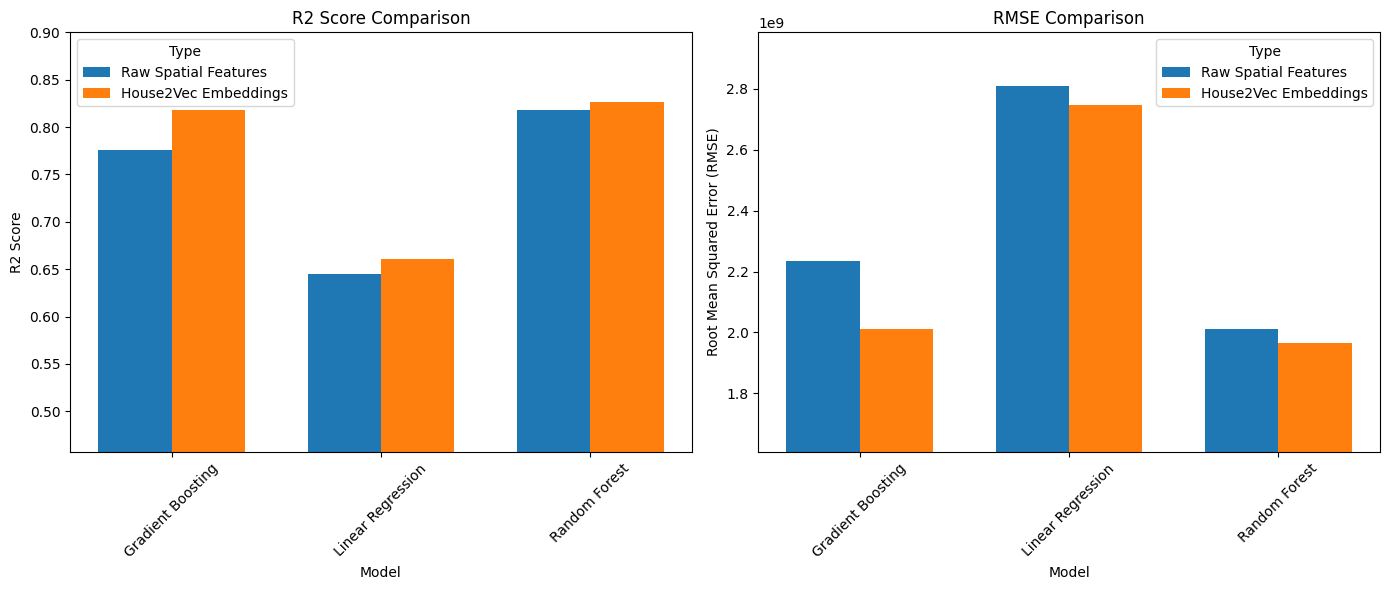

In [44]:
import pandas as pd  
import matplotlib.pyplot as plt  
import numpy as np  

# Load the DataFrame from the Excel file  
file_path = 'results/MHD/model_results.xlsx'  
df = pd.read_excel(file_path)  

# Create a new column to indicate if the model is DeepWalk or not  
df['Type'] = df['Model'].apply(lambda x: 'House2Vec Embeddings' if 'Node2Vec' in x else 'Raw Spatial Features')  

# Group the data by Model to get the mean R2 Score and RMSE  
summary_df = df.groupby(['Type', 'Model']).agg({'R2 Score': 'mean', 'RMSE': 'mean'}).reset_index()  

# Prepare data for plotting  
no_deepwalk = summary_df[summary_df['Type'] == 'Raw Spatial Features']  
deepwalk = summary_df[summary_df['Type'] == 'House2Vec Embeddings']  

# Calculate means for R2 Score and RMSE  
r2_mean = summary_df['R2 Score'].mean()  
rmse_mean = summary_df['RMSE'].mean()  

# Set the figure size for the plots  
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  

# Number of models  
num_models = len(no_deepwalk)  

# Set the bar width and x locations for the bars  
bar_width = 0.35  
x = np.arange(num_models)  

# Create bar plot for R2 Score comparison  
axs[0].bar(x - bar_width/2, no_deepwalk['R2 Score'], width=bar_width, label='Raw Spatial Features')  
axs[0].bar(x + bar_width/2, deepwalk['R2 Score'], width=bar_width, label='House2Vec Embeddings')  
axs[0].set_title('R2 Score Comparison')  
axs[0].set_xlabel('Model')  
axs[0].set_ylabel('R2 Score')  
axs[0].set_xticks(x)  
axs[0].set_xticklabels(no_deepwalk['Model'], rotation=45)  
axs[0].legend(title='Type')  

# Set the y-axis limits for R2 Score plot  
axs[0].set_ylim(r2_mean - 0.3, 0.9)  # Adjust the lower limit based on your data range  

# Create bar plot for RMSE comparison  
axs[1].bar(x - bar_width/2, no_deepwalk['RMSE'], width=bar_width, label='Raw Spatial Features')  
axs[1].bar(x + bar_width/2, deepwalk['RMSE'], width=bar_width, label='House2Vec Embeddings')  
axs[1].set_title('RMSE Comparison')  
axs[1].set_xlabel('Model')  
axs[1].set_ylabel('Root Mean Squared Error (RMSE)')  
axs[1].set_xticks(x)  
axs[1].set_xticklabels(no_deepwalk['Model'], rotation=45)  
axs[1].legend(title='Type')  

# Set the y-axis limits for RMSE plot  
axs[1].set_ylim(rmse_mean * 0.7, rmse_mean * 1.3)  # Adjust limits to give a better visualization  

# Adjust layout to prevent overlap  
plt.tight_layout()  

# Save the plot as a PNG file  
plt.savefig('results/MHD/model_comparison_side_by_side.png')  

# Show the plot  
plt.show()

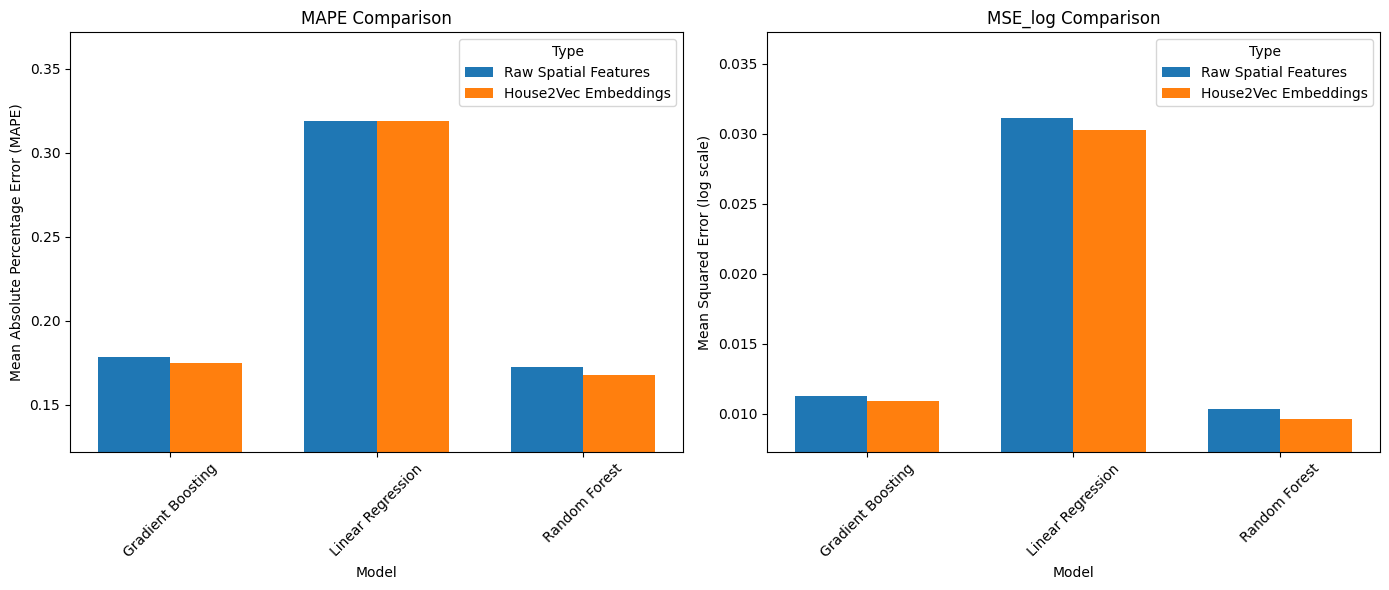

In [45]:
import pandas as pd  
import matplotlib.pyplot as plt  
import numpy as np  
from matplotlib.ticker import FuncFormatter

# Load the DataFrame from the Excel file  
file_path = 'results/MHD/model_results.xlsx'  
results_df = pd.read_excel(file_path)  

# Create a new column to indicate if the model is DeepWalk or not  
results_df['Type'] = results_df['Model'].apply(lambda x: 'House2Vec Embeddings' if 'Node2Vec' in x else 'Raw Spatial Features')  

# Group the data by Model to get the mean MAPE and MSE_log  
summary_df = results_df.groupby(['Type', 'Model']).agg({'MAPE': 'mean', 'MSE_log': 'mean'}).reset_index()  

# Prepare data for plotting  
no_deepwalk = summary_df[summary_df['Type'] == 'Raw Spatial Features']  
deepwalk = summary_df[summary_df['Type'] == 'House2Vec Embeddings']  

# Calculate means for MAPE and MSE_log  
mape_mean = summary_df['MAPE'].mean()  
mse_log_mean = summary_df['MSE_log'].mean()  

# Set the figure size for the plots  
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  

# Number of models  
num_models = len(no_deepwalk)  

# Set the bar width and x locations for the bars  
bar_width = 0.35  
x = np.arange(num_models)  

# Create bar plot for MAPE comparison  
axs[0].bar(x - bar_width/2, no_deepwalk['MAPE'], width=bar_width, label='Raw Spatial Features')  
axs[0].bar(x + bar_width/2, deepwalk['MAPE'], width=bar_width, label='House2Vec Embeddings')  
axs[0].set_title('MAPE Comparison')  
axs[0].set_xlabel('Model')  
axs[0].set_ylabel('Mean Absolute Percentage Error (MAPE)')  
axs[0].set_xticks(x)  
axs[0].set_xticklabels(no_deepwalk['Model'], rotation=45)  
axs[0].legend(title='Type')  

# Set the y-axis limits for MAPE plot  
axs[0].set_ylim(mape_mean - 0.1, mape_mean + 0.15)  # Adjust the limits based on your data range  

# Create bar plot for MSE_log comparison  
axs[1].bar(x - bar_width/2, no_deepwalk['MSE_log'], width=bar_width, label='Raw Spatial Features')  
axs[1].bar(x + bar_width/2, deepwalk['MSE_log'], width=bar_width, label='House2Vec Embeddings')  
axs[1].set_title('MSE_log Comparison')  
axs[1].set_xlabel('Model')  
axs[1].set_ylabel('Mean Squared Error (log scale)')  
axs[1].set_xticks(x)  
axs[1].set_xticklabels(no_deepwalk['Model'], rotation=45)  
axs[1].legend(title='Type')  

# Set the y-axis limits for MSE_log plot  
axs[1].set_ylim(mse_log_mean - 0.01, mse_log_mean + 0.02)  # Adjust limits to give a better visualization  

# Adjust layout to prevent overlap  
plt.tight_layout()  

# Save the plot as a PNG file  
plt.savefig('results/MHD/mape_mse_log_comparison_side_by_side.png')  

# Show the plot  
plt.show()

In [46]:
import networkx as nx  
import pandas as pd  
import matplotlib.pyplot as plt  

# Step 1: Calculate basic statistics  
num_nodes = G.number_of_nodes()  
num_edges = G.number_of_edges()  
degrees = [len(list(G.neighbors(node))) for node in G.nodes]  # List of number of neighbors for each node  

# Step 2: Compute minimum, maximum, and average number of neighbors  
min_neighbors = min(degrees)  
max_neighbors = max(degrees)  
avg_neighbors = sum(degrees) / num_nodes if num_nodes > 0 else 0  

# Step 3: Create a DataFrame for a better overview  
degree_distribution = pd.DataFrame({  
    'Node ID': list(G.nodes),  
    'Num Neighbors': degrees  
})  

# Step 4: Summary statistics of the degree distribution  
degree_stats = degree_distribution['Num Neighbors'].describe()  

# Step 5: Output the results  
print(f"Total number of nodes: {num_nodes}")  
print(f"Total number of edges: {num_edges}")  
print(f"Minimum number of neighbors: {min_neighbors}")  
print(f"Maximum number of neighbors: {max_neighbors}")  
print(f"Average number of neighbors: {avg_neighbors:.2f}")  
print("\nDegree Distribution Summary:")  
print(degree_stats)  

Total number of nodes: 5000
Total number of edges: 1415153
Minimum number of neighbors: 0
Maximum number of neighbors: 1514
Average number of neighbors: 566.06

Degree Distribution Summary:
count    5000.000000
mean      566.061200
std       638.224733
min         0.000000
25%        60.000000
50%       241.000000
75%      1514.000000
max      1514.000000
Name: Num Neighbors, dtype: float64


In [47]:
import pandas as pd  

# Load results from the Excel file  
results_df = pd.read_excel('results/MHD/model_results.xlsx')  

# Generate LaTeX longtable format  
latex_table = results_df.to_latex(index=False, escape=False, longtable=True, caption='Results of Regression Models', label='tab:regression_results')  

# Specify the filename for the LaTeX table  
latex_filename = 'results/MHD/results_table.tex'  

# Save the LaTeX table to a file  
with open(latex_filename, 'w') as f:  
    f.write(latex_table)  

# print(f"LaTeX table has been saved to {latex_filename}")

In [48]:
# import matplotlib.pyplot as plt  

# # Set up the environment for PGF  
# import matplotlib as mpl  
# mpl.use('pgf')  

# # You can set font and other parameters as needed  
# mpl.rcParams.update({  
#     "pgf.texsystem": "pdflatex",  
#     "font.family": "serif",  
#     "font.serif": [],  
#     "font.size": 12,  
#     "pgf.rcfonts": False,  
# })  

# # Create and save plots  
# def plot_results(results_df):  
#     metrics = ['R2 Score', 'MAPE', 'Accuracy', 'RMSE']  
#     models = results_df['Model']  

#     for metric in metrics:  
#         plt.figure(figsize=(10, 5))  
#         plt.bar(models, results_df[metric], color='skyblue')  
#         plt.title(f'{metric} of Regression Models')  
#         plt.xticks(rotation=45)  
#         plt.ylabel(metric)  
#         plt.tight_layout()  
#         plt.savefig(f'results/MHD/{metric.replace(" ", "_").lower()}.pgf')  # Save as PGF files  
#         plt.close()  

# plot_results(results_df)